---
title: LSTM (and RNN, GRU) fitting
---

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

## The LSTM Unit

Before fitting LSTM models, let us first see how the basic LSTM unit in PyTorcy (nn.LSTM) works (see \url{https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html} for details). 

To create the LSTM unit, we only need to specify the input_size (this is the dimension of $x_t$) and the number of hidden units (this is the dimension of $h_t, f_t, i_t, o_t, c_t$). 

In [4]:
lstm_net = nn.LSTM(input_size = 1, hidden_size = 5, batch_first = True)  

The above code line will create a LSTM unit and will randomly initialize all its parameters. Given a sequence $x_1, \dots, x_T$ for some $T$ (here each $x_t$ needs to be of dimension input_size), the LSTM unit will then use the formulas to compute $(c_1, h_1), \dots, (c_T, h_T)$. It will output $h_1, \dots, h_T$ as well as $(h_T, c_T)$. 

If we create two sets of input sequences $x_1, \dots, x_T$ and $\tilde{x}_1, \dots, \tilde{x}_T$, then the LSTM unit will use its formulae to output $h_1, \dots, h_T$ (as well as $(h_T, c_T)$) corresponding to $x_1, \dots, x_T$, as well as $\tilde{h}_1, \dots, \tilde{h}_T$, as well as $(\tilde{h}_T, \tilde{c}_T)$ corresponding to $\tilde{x}_1, \dots, \tilde{x}_T$. In general, if we send in $B$ input sequences (i.e., $B$ batches of input sequences), each sequence having length $T$ (and each $x$ in each sequence has dimension input_size), the output of the LSTM will correspond to $B$ sequences of length $T$ (each element of the sequence has dimension equal to hidden_size). The inputs and outputs can therefore both be treated as tensors. The 'batch_first = True' in the specification of lstm_net above indicates that the input tensor should have shape (B, T, input_size) and the output tensor will have shape (B, T, hidden_size). 

In [6]:
#Let us create an input tensor for lstm_net:
input = torch.randn(1, 10, 1) 
#this input has one batch, which is a sequence x_1, \dots, x_10 of length 10. Each x_t is a scalar (input_size = 1). 
print(input)

output, (hn, cn) = lstm_net(input)

#output will have shape (1, 10, 5). It is a simply the sequence h_1, \dots, h_10 where each h_t is of dimension hidden_size = 5. 
print(output.shape)

print(hn.shape) #h_n is simply the hidden vector h_t corresponding to the last time (here t = 10). You can check that hn is identical to the last element of the output

print(cn.shape) #c_n is the cell state corresponding to the last output

print(output[:, 9, :])
print(hn)
#check that hn and output[:, 9, :] are identical

tensor([[[-0.8748],
         [-1.5131],
         [ 0.5044],
         [-0.3878],
         [ 1.0426],
         [ 0.7758],
         [-2.0535],
         [ 1.3216],
         [-0.5709],
         [-0.1411]]])
torch.Size([1, 10, 5])
torch.Size([1, 1, 5])
torch.Size([1, 1, 5])
tensor([[ 0.0240, -0.1298,  0.1951, -0.0680,  0.1436]],
       grad_fn=<SliceBackward0>)
tensor([[[ 0.0240, -0.1298,  0.1951, -0.0680,  0.1436]]],
       grad_fn=<StackBackward0>)


The weight matrices $W_{ii}, W_{if}, W_{ig}, W_{io}$ as well as $W_{hi}, W_{hf}, W_{hg}, W_{ho}$, and the biases $b_{ii}, b_{if}, b_{ig}, b_{io}$ as well as $b_{hi}, b_{hf}, b_{hg}, b_{ho}$ can be accessed as follows. 

In [8]:
print(lstm_net.weight_ih_l0.shape)
print(lstm_net.weight_ih_l0) #this contains the four weight matrices W_{ii}, W_{if}, W_{ig}, W_{io}

print(lstm_net.weight_hh_l0.shape)
print(lstm_net.weight_hh_l0) #this contains the four weight matrices W_{hi}, W_{hf}, W_{hg}, W_{ho}

print(lstm_net.bias_ih_l0.shape) 
print(lstm_net.bias_ih_l0)  #this contains  the four biases b_{ii}, b_{if}, b_{ig}, b_{io}

print(lstm_net.bias_hh_l0.shape) 
print(lstm_net.bias_hh_l0)  #this contains  the four biases b_{hi}, b_{hf}, b_{hg}, b_{ho}

#0 here refers to the fact that there is a single LSTM layer. Sometimes, it is common to stack multiple LSTM units, in which case there will be weights and biases for each LSTM. We will only deal with a single LSTM layer



torch.Size([20, 1])
Parameter containing:
tensor([[-0.2318],
        [ 0.1864],
        [ 0.2214],
        [ 0.0846],
        [ 0.1032],
        [ 0.1183],
        [-0.4182],
        [ 0.0963],
        [ 0.0765],
        [-0.1803],
        [-0.3270],
        [ 0.3187],
        [-0.1421],
        [ 0.2497],
        [-0.0431],
        [-0.4423],
        [-0.2981],
        [ 0.0622],
        [ 0.1202],
        [-0.3805]], requires_grad=True)
torch.Size([20, 5])
Parameter containing:
tensor([[-0.1067, -0.1284,  0.0910, -0.4090,  0.3202],
        [ 0.3550,  0.0644, -0.3108,  0.2166,  0.2723],
        [-0.1922, -0.1219, -0.2929, -0.4380,  0.2305],
        [-0.3198,  0.2493, -0.3492, -0.0558, -0.0403],
        [-0.0872, -0.1000,  0.3376, -0.1066,  0.2932],
        [-0.4185,  0.3633, -0.2426, -0.2061, -0.2156],
        [-0.2836, -0.1734, -0.2273,  0.0486,  0.3997],
        [-0.3430,  0.1009,  0.1448,  0.1808,  0.0743],
        [-0.0858, -0.0531, -0.2424,  0.1392, -0.2152],
        [-0.2396, -0

The values that we see above for the weights and biases are randomly chosen initial values. Given some data, they will be trained so as to minimize some loss function. 

## Simulated Dataset One

Consider the following simple dataset. 

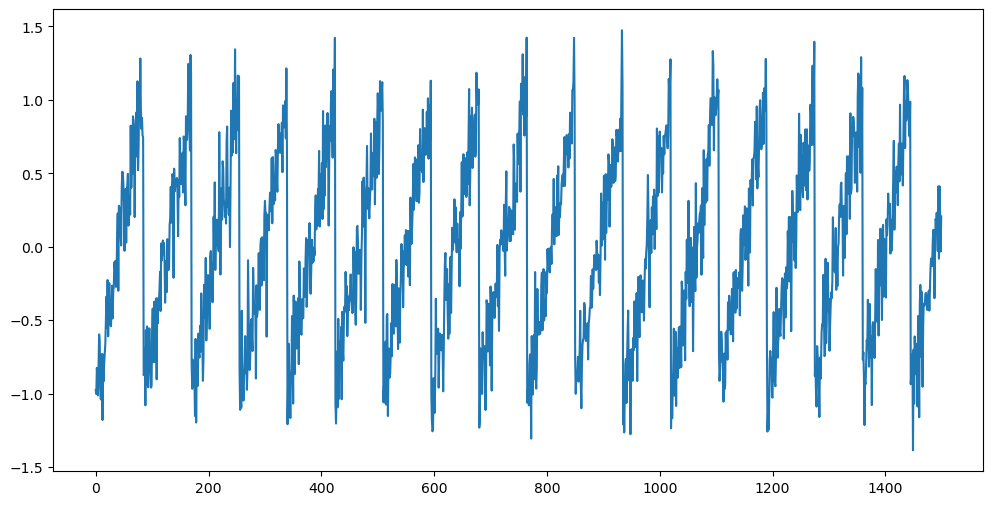

In [7]:
n = 1500
truelag = 85
rng = np.random.default_rng(seed = 0)
sig_noise = 0.2
eps = rng.normal(loc = 0, scale = sig_noise, size = n)
y_sim = np.full(shape = n, fill_value = -999.0)
y_sim[0:truelag] = np.linspace(-1, 1, truelag)
for i in range(truelag, n):
    y_sim[i] = y_sim[i - truelag] 
y_sim = y_sim + eps
plt.figure(figsize = (12, 6))
plt.plot(y_sim)
plt.show()

We first fit the AR($p$) model. If $p$ is taken to be smaller than the true lag which generated the data, the predictions will be quite poor. But the predictions are quite good when $p$ is exactly equal to the true lag. 

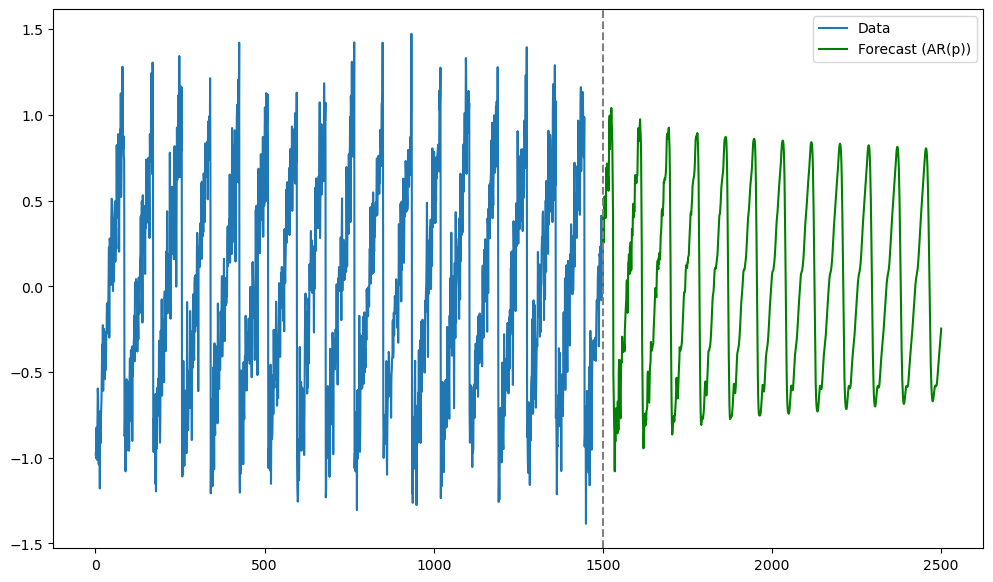

In [8]:
#Let us fit AR(p) with the truelag
p = truelag
ar = AutoReg(y_sim, lags = p).fit() 

n = len(y_sim)
tme = range(1, n+1)
n_future = 1000
tme_future = range(n+1, n+n_future+1)
fcast = ar.get_prediction(start = n, end = n+n_future-1).predicted_mean
plt.figure(figsize = (12, 7))
plt.plot(tme, y_sim, label = 'Data')
plt.plot(tme_future, fcast, label = 'Forecast (AR(p))', color = 'green')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

Next we apply LSTM (and RNN). The first step is to create the input and output tensors. 

In [9]:
mu, sig = y_sim.mean(), y_sim.std()
y_std = (y_sim - mu) / sig

X = torch.tensor(y_std[:-1], dtype=torch.float32)
Y = torch.tensor(y_std[1: ], dtype=torch.float32)

X = X.unsqueeze(0).unsqueeze(-1)   # shape (1, seq_len, 1)
Y = Y.unsqueeze(0).unsqueeze(-1)   # shape (1, seq_len, 1)

seq_len = X.size(1)
print(seq_len)

1499


We create the LSTM model class below. 

In [10]:
class lstm_net(nn.Module):
    def __init__(self, nh):
        super().__init__()
        self.rnn = nn.LSTM(input_size=1, hidden_size=nh,
                           batch_first=True)
        self.fc  = nn.Linear(nh, 1)          
    def forward(self, x, hc=None):
        out, hc = self.rnn(x, hc)           
        out     = self.fc(out)               
        return out, hc

#lstm_net defined above has an LSTM unit followed by a linear unit ('fc' stands for fully-connected) which converts the output of the LSTM to a scalar (this scalar is mu_t in our notation)

torch.manual_seed(0)
np.random.seed(0)

nh = 100
model = lstm_net(nh)
criterion = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)


Training is done as follows. 

In [11]:
n_epochs = 1000
for epoch in range(1, n_epochs + 1):
    model.train()
    opt.zero_grad()
    pred, _ = model(X)          
    loss = criterion(pred, Y)
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(f"epoch {epoch:4d}/{n_epochs}  |  loss = {loss.item():.6f}")

epoch  100/1000  |  loss = 0.238784
epoch  200/1000  |  loss = 0.183601
epoch  300/1000  |  loss = 0.178046
epoch  400/1000  |  loss = 0.165648
epoch  500/1000  |  loss = 0.161582
epoch  600/1000  |  loss = 0.155341
epoch  700/1000  |  loss = 0.151636
epoch  800/1000  |  loss = 0.158860
epoch  900/1000  |  loss = 0.158528
epoch 1000/1000  |  loss = 0.139661


Predictions are obtained as follows. 

In [12]:
model.eval()
with torch.no_grad():
    _, hc = model(X)
    preds = np.zeros(n_future, dtype=np.float32)
    last_in = torch.tensor([[y_std[-1]]], dtype=torch.float32)  # (1, 1, 1) after view
    for t in range(n_future):
        out, hc = model(last_in.view(1, 1, 1), hc)              # reuse hidden state
        next_val = out.squeeze().item()
        preds[t] = next_val
        last_in = torch.tensor([[next_val]], dtype=torch.float32)

Predictions are plotted below. 

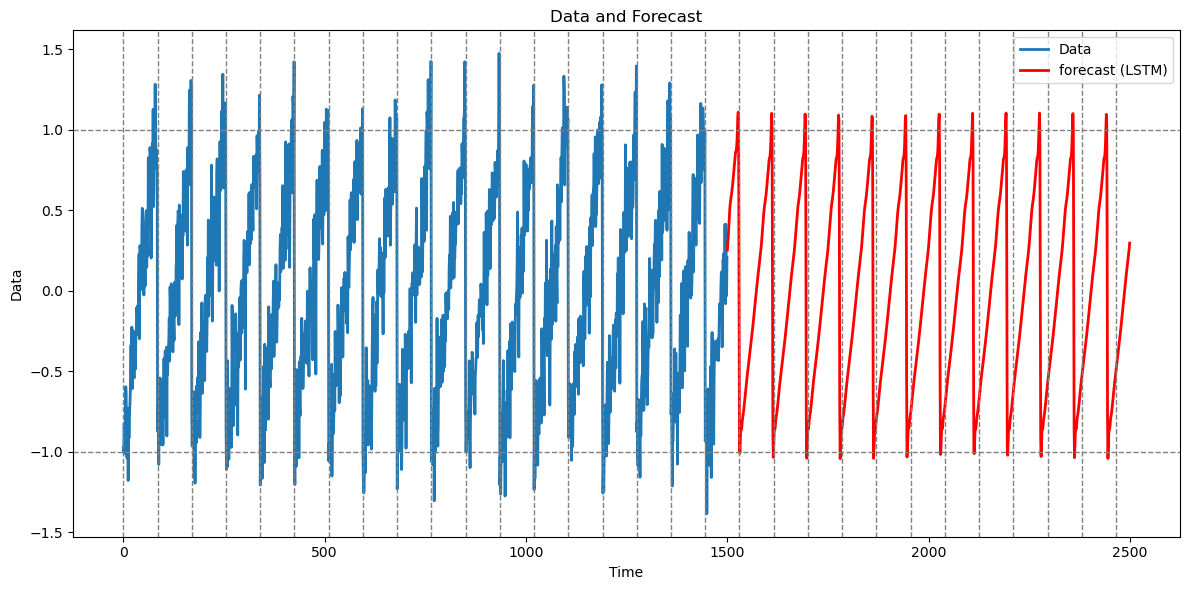

In [13]:
lstm_preds_orig = preds * sig + mu
tme_pred_axis = np.arange(n, n + n_future)

plt.figure(figsize=(12,6))
plt.plot(np.arange(n), y_sim, lw=2, label="Data")
plt.plot(tme_pred_axis, lstm_preds_orig, lw=2, color="r", label="forecast (LSTM)")
plt.xlabel("Time"); plt.ylabel("Data")
for t in range(0, n + n_future, truelag):
    plt.axvline(x=t, linestyle='--', color='gray', linewidth=1)
plt.axhline(y=1, linestyle='--', color='gray', linewidth=1)    
plt.axhline(y=-1, linestyle='--', color='gray', linewidth=1)    
plt.title("Data and Forecast")
plt.legend()
plt.tight_layout()
plt.show()

In the code above, the LSTM receives a single stream of length $T \approx 1500$ (with batch = 1), so every training step must iterate through 1500 recurrent updates, store all intermediate gate outputs, cell states, and hidden states for back-propagation-through-time, and then sweep backward through those same 1500 steps. The result is a high per-epoch cost--roughly proportional to $T$ both in floating-point operations and in memory. 

To make the code faster, we can attempt to chunk the original time series into a small number (say $3$) of batches of a smaller number (say 450) samples, and then to stack them so that the input tensor is of shape (3, 450, 1). Each forward/backward pass now unrolls only 450 steps (a 3.3 times reduction) and the three batches can even be procesed in parallel along the batch dimension. This combination of a shallower time depth and batching typically leads to a speed up in the code. However, the trade‑off is that the hidden state is implicitly reset at every window boundary, so the model cannot capture dependencies that span more than 450 time steps; for tasks that truly require very long‑range memory, the slower single‑sequence approach is safer.

Below we illustrate this batching idea. 

### Batching

In [15]:
seq_len_batch = 450
n_batches = (len(y_std) - 1) // seq_len_batch
print(n_batches)

X_batches = []
Y_batches = []
for i in range(n_batches): 
    start_idx = i * seq_len_batch
    end_idx = start_idx + seq_len_batch
    X_batches.append(y_std[start_idx : end_idx])
    Y_batches.append(y_std[(start_idx + 1): (end_idx + 1)])

X = torch.tensor(X_batches, dtype = torch.float32).unsqueeze(-1)
Y = torch.tensor(Y_batches, dtype = torch.float32).unsqueeze(-1)

print(X.shape)
print(Y.shape)


3
torch.Size([3, 450, 1])
torch.Size([3, 450, 1])


In [16]:
class lstm_net(nn.Module):
    def __init__(self, nh):
        super().__init__()
        self.rnn = nn.LSTM(input_size=1, hidden_size=nh,
                           batch_first=True)
        self.fc  = nn.Linear(nh, 1)          # many-to-many
    def forward(self, x, hc=None):
        out, hc = self.rnn(x, hc)            # out: (B, T, nh)
        out     = self.fc(out)               # (B, T, 1)
        return out, hc

torch.manual_seed(0)
np.random.seed(0)

nh = 100
model = lstm_net(nh)
criterion = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [17]:
n_epochs = 1000
for epoch in range(1, n_epochs + 1):
    model.train()
    opt.zero_grad()
    pred, _ = model(X)          
    loss = criterion(pred, Y)
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(f"epoch {epoch:4d}/{n_epochs}  |  loss = {loss.item():.6f}")

epoch  100/1000  |  loss = 0.235551
epoch  200/1000  |  loss = 0.190747
epoch  300/1000  |  loss = 0.169411
epoch  400/1000  |  loss = 0.158637
epoch  500/1000  |  loss = 0.159057
epoch  600/1000  |  loss = 0.144519
epoch  700/1000  |  loss = 0.151861
epoch  800/1000  |  loss = 0.132501
epoch  900/1000  |  loss = 0.123780
epoch 1000/1000  |  loss = 0.176492


Once the model is trained, I revert back to the previous $X$ and $Y$ (without batching) in order to calculate predictions. 

1499


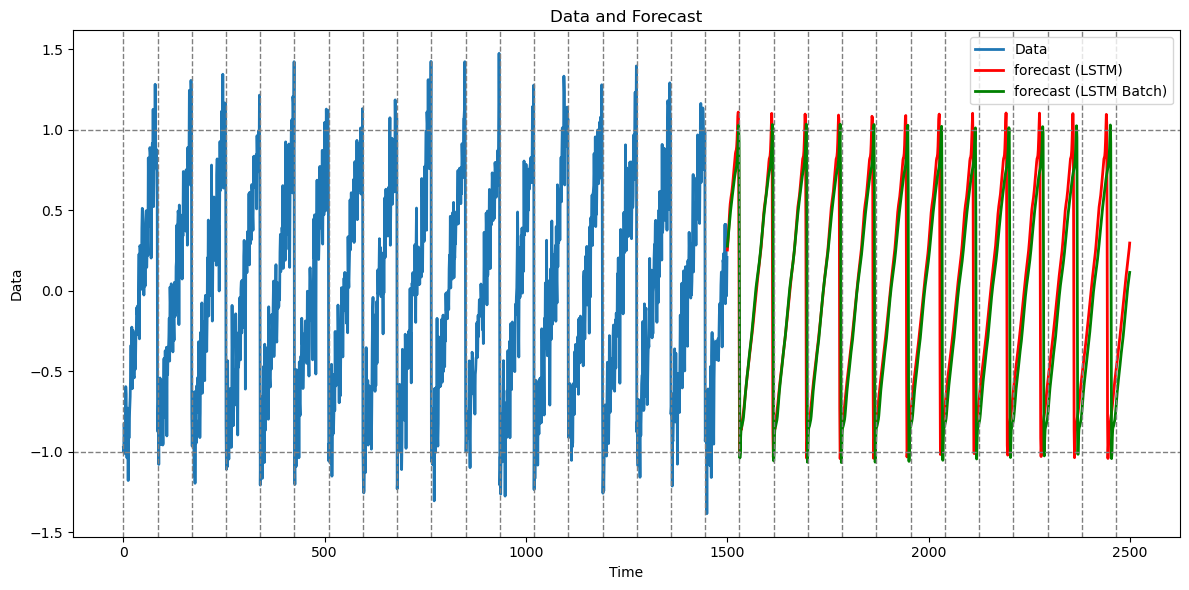

In [18]:
mu, sig = y_sim.mean(), y_sim.std()
y_std = (y_sim - mu) / sig

X = torch.tensor(y_std[:-1], dtype=torch.float32)
Y = torch.tensor(y_std[1: ], dtype=torch.float32)

X = X.unsqueeze(0).unsqueeze(-1)   # shape (1, seq_len, 1)
Y = Y.unsqueeze(0).unsqueeze(-1)   # shape (1, seq_len, 1)

seq_len = X.size(1)
print(seq_len)

model.eval()
with torch.no_grad():
    _, hc = model(X)
    preds = np.zeros(n_future, dtype=np.float32)
    last_in = torch.tensor([[y_std[-1]]], dtype=torch.float32)  # (1, 1, 1) after view
    for t in range(n_future):
        out, hc = model(last_in.view(1, 1, 1), hc)              # reuse hidden state
        next_val = out.squeeze().item()
        preds[t] = next_val
        last_in = torch.tensor([[next_val]], dtype=torch.float32)

lstm_preds_orig_batch = preds * sig + mu
tme_pred_axis = np.arange(n, n + n_future)

plt.figure(figsize=(12,6))
plt.plot(np.arange(n), y_sim, lw=2, label="Data")
plt.plot(tme_pred_axis, lstm_preds_orig, lw=2, color="r", label="forecast (LSTM)")
plt.plot(tme_pred_axis, lstm_preds_orig_batch, lw=2, color="green", label="forecast (LSTM Batch)")
plt.xlabel("Time"); plt.ylabel("Data")
plt.title("Data and Forecast")
for t in range(0, n + n_future, truelag):
    plt.axvline(x=t, linestyle='--', color='gray', linewidth=1)
plt.axhline(y=1, linestyle='--', color='gray', linewidth=1)    
plt.axhline(y=-1, linestyle='--', color='gray', linewidth=1)    
plt.legend()
plt.tight_layout()
plt.show()

In this example, the predictions with and without batching are nearly identical. However batching makes the code run much faster. 

Let us now fit the RNN. 

In [19]:
class RNNReg(nn.Module):
    def __init__(self, nh):
        super().__init__()
        self.rnn = nn.RNN(1, nh, nonlinearity="tanh", batch_first=True)
        self.fc  = nn.Linear(nh, 1)
    def forward(self, x, h=None):
        out, h = self.rnn(x, h)
        return self.fc(out), h

nh = 50
model = RNNReg(nh)
criterion = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(),lr = 1e-3)

In [20]:
n_epochs = 1000
for epoch in range(1, n_epochs + 1):
    model.train()
    opt.zero_grad()
    pred, _ = model(X)           
    loss = criterion(pred, Y)
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(f"epoch {epoch:4d}/{n_epochs}  |  loss = {loss.item():.6f}")

epoch  100/1000  |  loss = 0.283465
epoch  200/1000  |  loss = 0.230474
epoch  300/1000  |  loss = 0.199063
epoch  400/1000  |  loss = 0.190025
epoch  500/1000  |  loss = 0.182842
epoch  600/1000  |  loss = 0.219429
epoch  700/1000  |  loss = 0.221646
epoch  800/1000  |  loss = 0.171874
epoch  900/1000  |  loss = 0.169135
epoch 1000/1000  |  loss = 0.171711


In [21]:
model.eval()
with torch.no_grad():
    _, h = model(X)                 
    preds = np.zeros(n_future, np.float32)
    last  = torch.tensor([[y_std[-1]]], dtype=torch.float32)
    for t in range(n_future):
        out, h = model(last.view(1,1,1), h)
        preds[t] = out.item()
        last = torch.tensor([[preds[t]]], dtype=torch.float32)


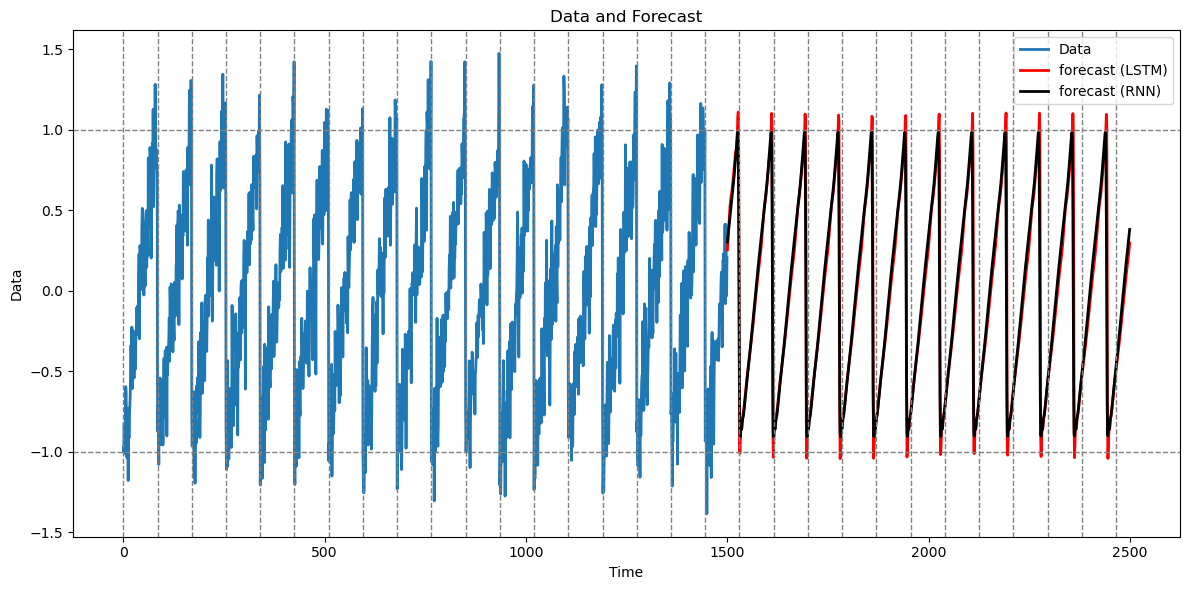

In [22]:
rnn_preds_orig = preds * sig + mu
tme_pred_axis = np.arange(n, n + n_future)

plt.figure(figsize=(12,6))
plt.plot(np.arange(n), y_sim, lw=2, label="Data")
plt.plot(tme_pred_axis, lstm_preds_orig, lw=2, color="red", label="forecast (LSTM)")
plt.plot(tme_pred_axis, rnn_preds_orig, lw=2, color="black", label="forecast (RNN)")

for t in range(0, n + n_future, truelag):
    plt.axvline(x=t, linestyle='--', color='gray', linewidth=1)

plt.axhline(y=1, linestyle='--', color='gray', linewidth=1)    
plt.axhline(y=-1, linestyle='--', color='gray', linewidth=1)    

plt.xlabel("Time"); plt.ylabel("Data")
plt.title("Data and Forecast")
plt.legend()
plt.tight_layout()
plt.show()

RNN gives predictions that are basically the same as the LSTM predictions. 

# Simulated Dataset Two

We now make two changes to the first simulation above. We increase the true lag. We also add noise slightly differently (noise is now added to the equation $y_t = y_{t-\text{truelag}} + \epsilon_t$). 

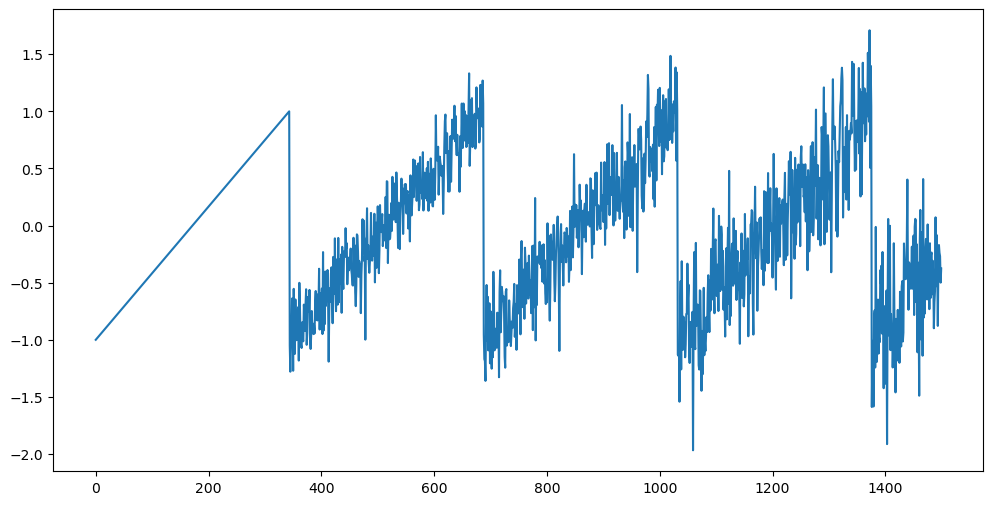

In [23]:
n = 1500
truelag = 344 
rng = np.random.default_rng(seed = 0)
sig_noise = 0.2
eps = rng.normal(loc = 0, scale = sig_noise, size = n)
y_sim = np.full(shape = n, fill_value = -999.0)
y_sim[0:truelag] = np.linspace(-1, 1, truelag)
for i in range(truelag, n):
    y_sim[i] = y_sim[i - truelag] + eps[i]
#y_sim = y_sim + eps
plt.figure(figsize = (12, 6))
plt.plot(y_sim)
plt.show()

This is a long range prediction problem. In this example, AR($p$) with $p$ taken to be the true lag gives very noisy predictions (as shown below) 

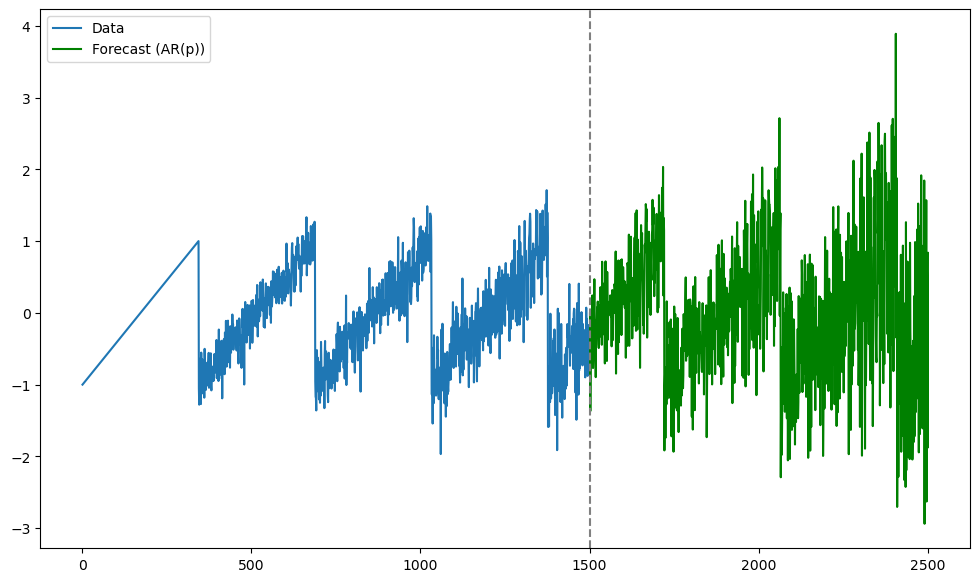

In [24]:
#Let us fit AR(p)
p = truelag
ar = AutoReg(y_sim, lags = p).fit() 

n = len(y_sim)
tme = range(1, n+1)
n_future = 1000
tme_future = range(n+1, n+n_future+1)
fcast = ar.get_prediction(start = n, end = n+n_future-1).predicted_mean
plt.figure(figsize = (12, 7))
plt.plot(tme, y_sim, label = 'Data')
plt.plot(tme_future, fcast, label = 'Forecast (AR(p))', color = 'green')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

Let us see how the LSTM and RNN do. First we fit LSTM without any batching. 

In [25]:
mu, sig = y_sim.mean(), y_sim.std()
y_std = (y_sim - mu) / sig

X = torch.tensor(y_std[:-1], dtype=torch.float32)
Y = torch.tensor(y_std[1: ], dtype=torch.float32)

X = X.unsqueeze(0).unsqueeze(-1)   # shape (1, seq_len, 1)
Y = Y.unsqueeze(0).unsqueeze(-1)   # shape (1, seq_len, 1)

seq_len = X.size(1)
print(seq_len)

1499


In [26]:
class lstm_net(nn.Module):
    def __init__(self, nh):
        super().__init__()
        self.rnn = nn.LSTM(input_size=1, hidden_size=nh,
                           batch_first=True)
        self.fc  = nn.Linear(nh, 1)          
    def forward(self, x, hc=None):
        out, hc = self.rnn(x, hc)           
        out     = self.fc(out)               
        return out, hc

torch.manual_seed(0)
np.random.seed(0)

nh = 100
model = lstm_net(nh)
criterion = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)


In [27]:
n_epochs = 1000
for epoch in range(1, n_epochs + 1):
    model.train()
    opt.zero_grad()
    pred, _ = model(X)          
    loss = criterion(pred, Y)
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(f"epoch {epoch:4d}/{n_epochs}  |  loss = {loss.item():.6f}")

epoch  100/1000  |  loss = 0.234757
epoch  200/1000  |  loss = 0.207985
epoch  300/1000  |  loss = 0.206311
epoch  400/1000  |  loss = 0.195433
epoch  500/1000  |  loss = 0.189044
epoch  600/1000  |  loss = 0.179978
epoch  700/1000  |  loss = 0.173883
epoch  800/1000  |  loss = 0.174173
epoch  900/1000  |  loss = 0.168488
epoch 1000/1000  |  loss = 0.162189


In [28]:
model.eval()
with torch.no_grad():
    _, hc = model(X)
    preds = np.zeros(n_future, dtype=np.float32)
    last_in = torch.tensor([[y_std[-1]]], dtype=torch.float32)  # (1, 1, 1) after view
    for t in range(n_future):
        out, hc = model(last_in.view(1, 1, 1), hc)              # reuse hidden state
        next_val = out.squeeze().item()
        preds[t] = next_val
        last_in = torch.tensor([[next_val]], dtype=torch.float32)

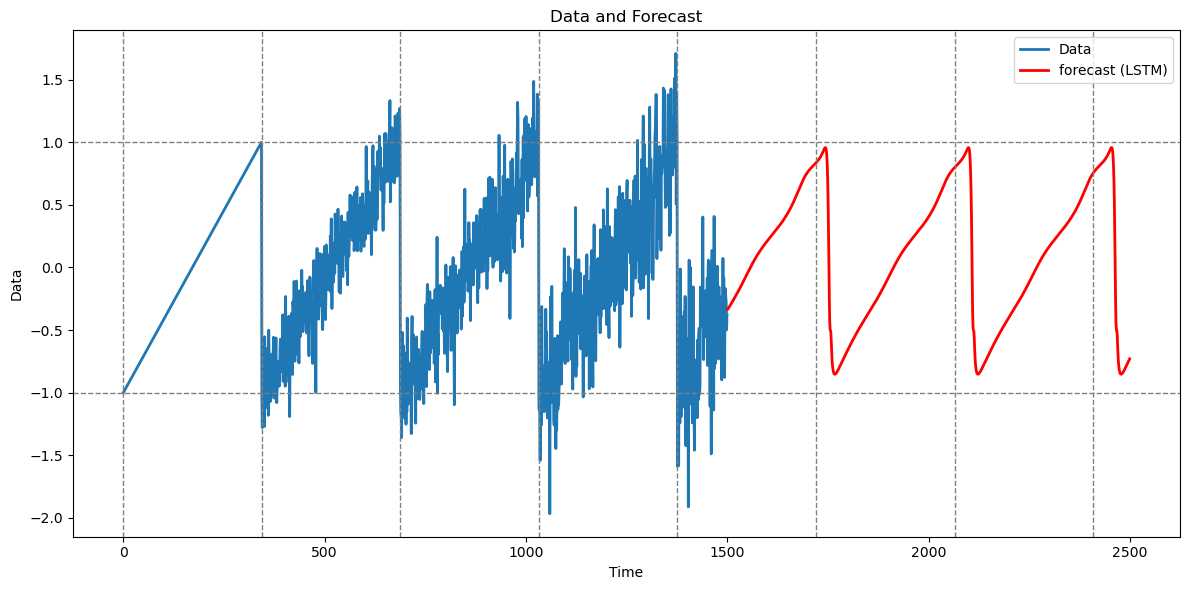

In [29]:
lstm_preds_orig = preds * sig + mu
tme_pred_axis = np.arange(n, n + n_future)

plt.figure(figsize=(12,6))
plt.plot(np.arange(n), y_sim, lw=2, label="Data")
plt.plot(tme_pred_axis, lstm_preds_orig, lw=2, color="r", label="forecast (LSTM)")
plt.xlabel("Time"); plt.ylabel("Data")
for t in range(0, n + n_future, truelag):
    plt.axvline(x=t, linestyle='--', color='gray', linewidth=1)
plt.axhline(y=1, linestyle='--', color='gray', linewidth=1)    
plt.axhline(y=-1, linestyle='--', color='gray', linewidth=1)    
plt.title("Data and Forecast")
plt.legend()
plt.tight_layout()
plt.show()

The predictions are decent. Note that the nature of the predictions (which seem quite clean) is quite different from the predictions given by the AR model (these were very noisy).  

Now let us apply batching. 

In [54]:
seq_len_batch = 650
n_batches = (len(y_std) - 1) // seq_len_batch
print(n_batches)

X_batches = []
Y_batches = []
for i in range(n_batches): 
    start_idx = i * seq_len_batch
    end_idx = start_idx + seq_len_batch
    X_batches.append(y_std[start_idx : end_idx])
    Y_batches.append(y_std[(start_idx + 1): (end_idx + 1)])

X = torch.tensor(X_batches, dtype = torch.float32).unsqueeze(-1)
Y = torch.tensor(Y_batches, dtype = torch.float32).unsqueeze(-1)

print(X.shape)
print(Y.shape)


2
torch.Size([2, 650, 1])
torch.Size([2, 650, 1])


In [55]:
class lstm_net(nn.Module):
    def __init__(self, nh):
        super().__init__()
        self.rnn = nn.LSTM(input_size=1, hidden_size=nh,
                           batch_first=True)
        self.fc  = nn.Linear(nh, 1)         
    def forward(self, x, hc=None):
        out, hc = self.rnn(x, hc)            
        out     = self.fc(out)              
        return out, hc

torch.manual_seed(0)
np.random.seed(0)

nh = 100
model = lstm_net(nh)
criterion = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [56]:
n_epochs = 1000
for epoch in range(1, n_epochs + 1):
    model.train()
    opt.zero_grad()
    pred, _ = model(X)          
    loss = criterion(pred, Y)
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(f"epoch {epoch:4d}/{n_epochs}  |  loss = {loss.item():.6f}")

epoch  100/1000  |  loss = 0.196386
epoch  200/1000  |  loss = 0.172178
epoch  300/1000  |  loss = 0.158832
epoch  400/1000  |  loss = 0.158074
epoch  500/1000  |  loss = 0.177489
epoch  600/1000  |  loss = 0.157444
epoch  700/1000  |  loss = 0.150786
epoch  800/1000  |  loss = 0.147682
epoch  900/1000  |  loss = 0.143554
epoch 1000/1000  |  loss = 0.136835


1499


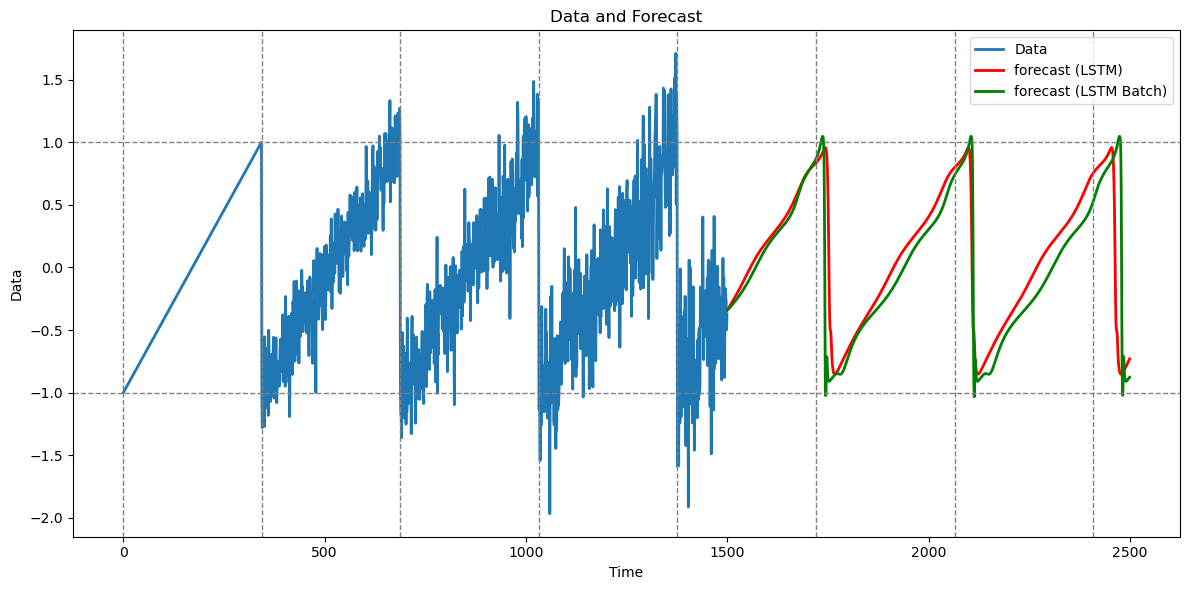

In [57]:
mu, sig = y_sim.mean(), y_sim.std()
y_std = (y_sim - mu) / sig

X = torch.tensor(y_std[:-1], dtype=torch.float32)
Y = torch.tensor(y_std[1: ], dtype=torch.float32)

X = X.unsqueeze(0).unsqueeze(-1)   # shape (1, seq_len, 1)
Y = Y.unsqueeze(0).unsqueeze(-1)   # shape (1, seq_len, 1)

seq_len = X.size(1)
print(seq_len)

model.eval()
with torch.no_grad():
    _, hc = model(X)
    preds = np.zeros(n_future, dtype=np.float32)
    last_in = torch.tensor([[y_std[-1]]], dtype=torch.float32)  # (1, 1, 1) after view
    for t in range(n_future):
        out, hc = model(last_in.view(1, 1, 1), hc)              # reuse hidden state
        next_val = out.squeeze().item()
        preds[t] = next_val
        last_in = torch.tensor([[next_val]], dtype=torch.float32)

lstm_preds_orig_batch = preds * sig + mu
tme_pred_axis = np.arange(n, n + n_future)

plt.figure(figsize=(12,6))
plt.plot(np.arange(n), y_sim, lw=2, label="Data")
plt.plot(tme_pred_axis, lstm_preds_orig, lw=2, color="r", label="forecast (LSTM)")
plt.plot(tme_pred_axis, lstm_preds_orig_batch, lw=2, color="green", label="forecast (LSTM Batch)")
plt.xlabel("Time"); plt.ylabel("Data")
plt.title("Data and Forecast")
for t in range(0, n + n_future, truelag):
    plt.axvline(x=t, linestyle='--', color='gray', linewidth=1)
plt.axhline(y=1, linestyle='--', color='gray', linewidth=1)    
plt.axhline(y=-1, linestyle='--', color='gray', linewidth=1)    
plt.legend()
plt.tight_layout()
plt.show()

The predictions with and without batching are similar (I am using sequence length equaling 650 here; for different values of this parameter, the predictions seem different from the full-sequence predictions). 

RNN does not seem to work for this predictions as shown below (this is because of the lack of ability to capture long range dependencies). 

In [58]:
class RNNReg(nn.Module):
    def __init__(self, nh):
        super().__init__()
        self.rnn = nn.RNN(1, nh, nonlinearity="tanh", batch_first=True)
        self.fc  = nn.Linear(nh, 1)
    def forward(self, x, h=None):
        out, h = self.rnn(x, h)
        return self.fc(out), h

nh = 50 #I could not find any value of nh for which the RNN is giving good predictions for this data
model = RNNReg(nh)
criterion = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(),lr = 1e-3)

In [59]:
n_epochs = 1000
for epoch in range(1, n_epochs + 1):
    model.train()
    opt.zero_grad()
    pred, _ = model(X)           
    loss = criterion(pred, Y)
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(f"epoch {epoch:4d}/{n_epochs}  |  loss = {loss.item():.6f}")

epoch  100/1000  |  loss = 0.234295
epoch  200/1000  |  loss = 0.228924
epoch  300/1000  |  loss = 0.224068
epoch  400/1000  |  loss = 0.208632
epoch  500/1000  |  loss = 0.220152
epoch  600/1000  |  loss = 0.195136
epoch  700/1000  |  loss = 0.190942
epoch  800/1000  |  loss = 0.219482
epoch  900/1000  |  loss = 0.197227
epoch 1000/1000  |  loss = 0.197343


In [60]:
model.eval()
with torch.no_grad():
    _, h = model(X)                 
    preds = np.zeros(n_future, np.float32)
    last  = torch.tensor([[y_std[-1]]], dtype=torch.float32)
    for t in range(n_future):
        out, h = model(last.view(1,1,1), h)
        preds[t] = out.item()
        last = torch.tensor([[preds[t]]], dtype=torch.float32)


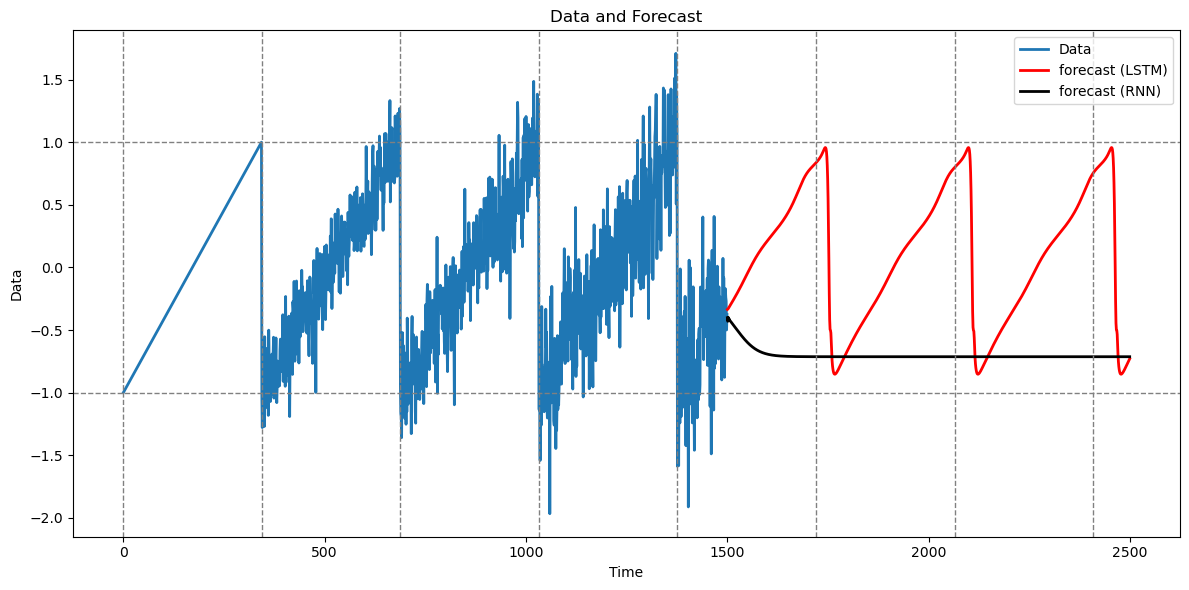

In [61]:
rnn_preds_orig = preds * sig + mu
tme_pred_axis = np.arange(n, n + n_future)

plt.figure(figsize=(12,6))
plt.plot(np.arange(n), y_sim, lw=2, label="Data")
plt.plot(tme_pred_axis, lstm_preds_orig, lw=2, color="red", label="forecast (LSTM)")
plt.plot(tme_pred_axis, rnn_preds_orig, lw=2, color="black", label="forecast (RNN)")

for t in range(0, n + n_future, truelag):
    plt.axvline(x=t, linestyle='--', color='gray', linewidth=1)

plt.axhline(y=1, linestyle='--', color='gray', linewidth=1)    
plt.axhline(y=-1, linestyle='--', color='gray', linewidth=1)    

plt.xlabel("Time"); plt.ylabel("Data")
plt.title("Data and Forecast")
plt.legend()
plt.tight_layout()
plt.show()

## Sunspots Data

Below we apply LSTM, RNN and GRU to obtain predictions for the sunspots dataset. 

        0     1    2  3  4
0  1700.5   8.3 -1.0 -1  1
1  1701.5  18.3 -1.0 -1  1
2  1702.5  26.7 -1.0 -1  1
3  1703.5  38.3 -1.0 -1  1
4  1704.5  60.0 -1.0 -1  1


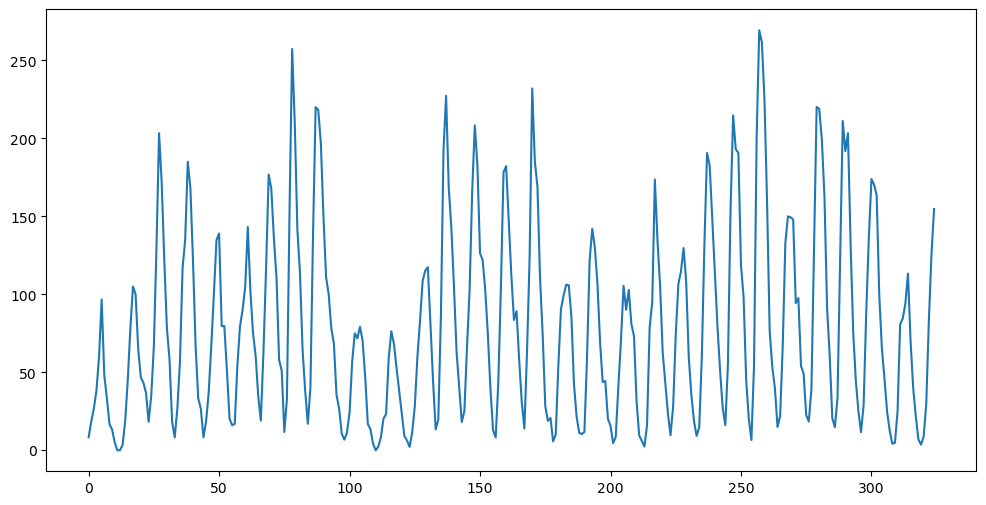

325


In [63]:
sunspots = pd.read_csv('SN_y_tot_V2.0.csv', header = None, sep = ';')
print(sunspots.head())
y = sunspots.iloc[:,1].values
n = len(y)
plt.figure(figsize = (12, 6))
plt.plot(y)
plt.show()
print(n)
n_future = 300

Because the data size is not very large, we do not use any batching and directly apply the models on the full sequence. First we prepare $X$ and $Y$. 

In [64]:
mu, sig = y.mean(), y.std()
y_std = (y - mu) / sig

X = torch.tensor(y_std[:-1], dtype=torch.float32)
Y = torch.tensor(y_std[1: ], dtype=torch.float32)

X = X.unsqueeze(0).unsqueeze(-1)   # shape (1, seq_len, 1)
Y = Y.unsqueeze(0).unsqueeze(-1)   # shape (1, seq_len, 1)

seq_len = X.size(1)
print(seq_len)

324


We fit LSTM with the number of hidden units equaling 200. 

## LSTM for Sunspots

In [65]:
class lstm_net(nn.Module):
    def __init__(self, nh):
        super().__init__()
        self.rnn = nn.LSTM(input_size=1, hidden_size=nh,
                           batch_first=True)
        self.fc  = nn.Linear(nh, 1)          
    def forward(self, x, hc=None):
        out, hc = self.rnn(x, hc)           
        out     = self.fc(out)               
        return out, hc

torch.manual_seed(0)
np.random.seed(0)

nh = 200
model = lstm_net(nh)
criterion = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)


In [66]:
n_epochs = 1000
for epoch in range(1, n_epochs + 1):
    model.train()
    opt.zero_grad()
    pred, _ = model(X)          
    loss = criterion(pred, Y)
    loss.backward()
    opt.step()

    if epoch % 100 == 0:
        print(f"epoch {epoch:4d}/{n_epochs}  |  loss = {loss.item():.6f}")

epoch  100/1000  |  loss = 0.126732
epoch  200/1000  |  loss = 0.059227
epoch  300/1000  |  loss = 0.040492
epoch  400/1000  |  loss = 0.015958
epoch  500/1000  |  loss = 0.016379
epoch  600/1000  |  loss = 0.012615
epoch  700/1000  |  loss = 0.005350
epoch  800/1000  |  loss = 0.005683
epoch  900/1000  |  loss = 0.001991
epoch 1000/1000  |  loss = 0.001579


In [67]:
model.eval()
with torch.no_grad():
    _, hc = model(X)
    preds = np.zeros(n_future, dtype=np.float32)
    last_in = torch.tensor([[y_std[-1]]], dtype=torch.float32)  # (1, 1, 1) after view
    for t in range(n_future):
        out, hc = model(last_in.view(1, 1, 1), hc)              # reuse hidden state
        next_val = out.squeeze().item()
        preds[t] = next_val
        last_in = torch.tensor([[next_val]], dtype=torch.float32)

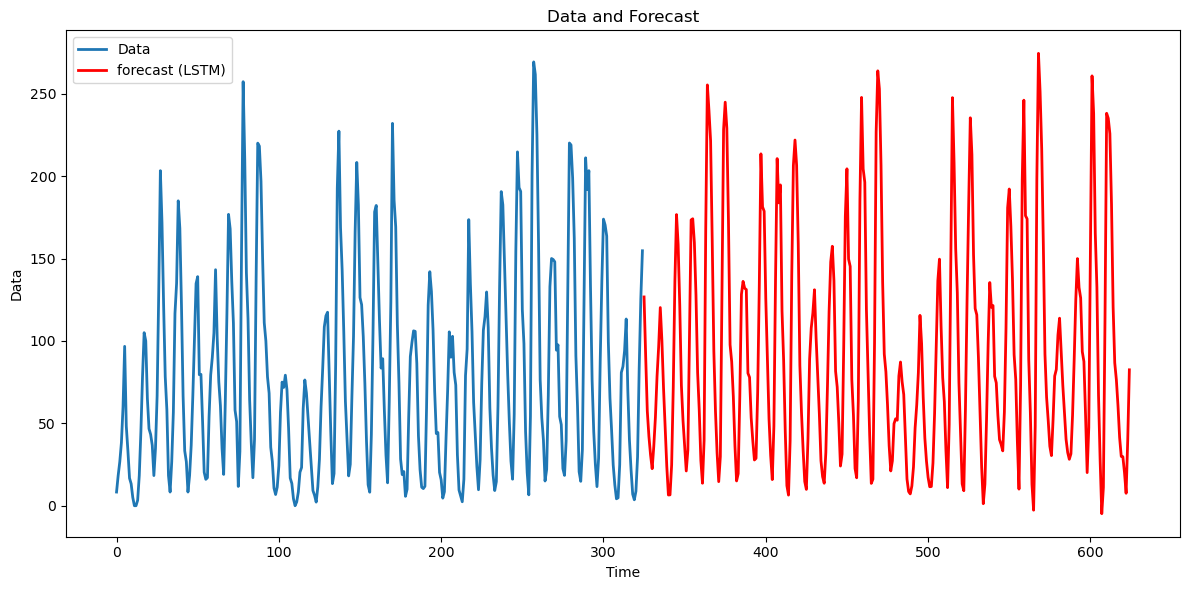

In [68]:
lstm_preds_orig = preds * sig + mu
tme_pred_axis = np.arange(n, n + n_future)

plt.figure(figsize=(12,6))
plt.plot(np.arange(n), y, lw=2, label="Data")
plt.plot(tme_pred_axis, lstm_preds_orig, lw=2, color="r", label="forecast (LSTM)")
plt.xlabel("Time"); plt.ylabel("Data")
plt.title("Data and Forecast")
plt.legend()
plt.tight_layout()
plt.show()

The predictions for the LSTM look quite realistic. They are quite different in characteristic from the predictions generated by an AR($p$) model (the AR($p$) predictions oscillate for a short while before settling to a constant value; in contrast, the LSTM predictions seem to oscillate well into the future in a way that is visually similar to the true dataset). 

## RNN for Sunspots

Next we apply the RNN (again with 200 hidden units). 

In [69]:
torch.manual_seed(0)
np.random.seed(0)

nh = 200
class RNNReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(1, nh, nonlinearity="tanh", batch_first=True)
        self.fc  = nn.Linear(nh, 1)
    def forward(self, x, h=None):
        out, h = self.rnn(x, h)
        return self.fc(out), h

model = RNNReg()
opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
lossf = nn.MSELoss()


for epoch in range(1000):
    opt.zero_grad()
    pred,_ = model(X)
    loss   = lossf(pred, Y)
    loss.backward();  opt.step()
    if epoch % 100 == 0:
        print(f"epoch {epoch:4d}/{n_epochs}  |  loss = {loss.item():.6f}")

epoch    0/1000  |  loss = 1.003679
epoch  100/1000  |  loss = 0.141562
epoch  200/1000  |  loss = 0.082867
epoch  300/1000  |  loss = 0.056757
epoch  400/1000  |  loss = 0.047312
epoch  500/1000  |  loss = 0.025869
epoch  600/1000  |  loss = 0.014358
epoch  700/1000  |  loss = 0.008335
epoch  800/1000  |  loss = 0.133992
epoch  900/1000  |  loss = 0.089119


In [70]:
model.eval()
with torch.no_grad():
    _, h = model(X)                       
    preds = np.zeros(n_future, np.float32)
    last  = torch.tensor([[y_std[-1]]], dtype=torch.float32)
    for t in range(n_future):
        out, h = model(last.view(1,1,1), h)
        preds[t] = out.item()
        last = torch.tensor([[preds[t]]], dtype=torch.float32)

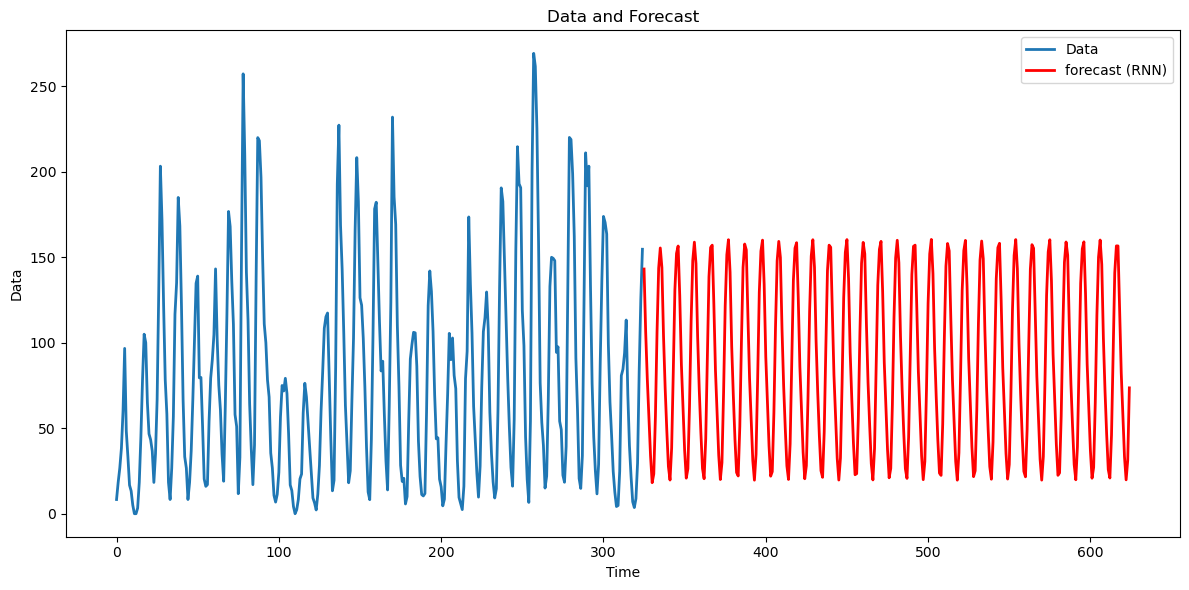

In [71]:
rnn_preds_orig = preds*sig + mu
tme_pred_axis = np.arange(n, n + n_future)

plt.figure(figsize=(12,6))
plt.plot(np.arange(n), y, lw=2, label="Data")
plt.plot(tme_pred_axis, rnn_preds_orig, lw=2, color="r", label="forecast (RNN)")
plt.xlabel("Time"); plt.ylabel("Data")
plt.title("Data and Forecast")
plt.legend()
plt.tight_layout()
plt.show()

These predictions do not appear as realistic as the LSTM forecasts. 

## GRU for Sunspots

Below we fit the GRU again with 200 hidden units. The code works in exactly the same way as LSTM and RNN.

In [72]:
torch.manual_seed(0)
np.random.seed(0)

nh = 200
class GRUReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(1, nh, batch_first=True)
        self.fc  = nn.Linear(nh,1)
    def forward(self,x,h=None):
        out,h = self.gru(x,h)
        return self.fc(out),h
model = GRUReg()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
lossf = nn.MSELoss()

In [73]:
for epoch in range(1000):
    opt.zero_grad()
    pred,_ = model(X)
    loss = lossf(pred, Y)
    loss.backward(); opt.step()
    if epoch % 100 == 0:
        print(f"epoch {epoch:4d}/{n_epochs}  |  loss = {loss.item():.6f}")

epoch    0/1000  |  loss = 1.034648
epoch  100/1000  |  loss = 0.124171
epoch  200/1000  |  loss = 0.071740
epoch  300/1000  |  loss = 0.042880
epoch  400/1000  |  loss = 0.033138
epoch  500/1000  |  loss = 0.068680
epoch  600/1000  |  loss = 0.018391
epoch  700/1000  |  loss = 0.074656
epoch  800/1000  |  loss = 0.030435
epoch  900/1000  |  loss = 0.017239


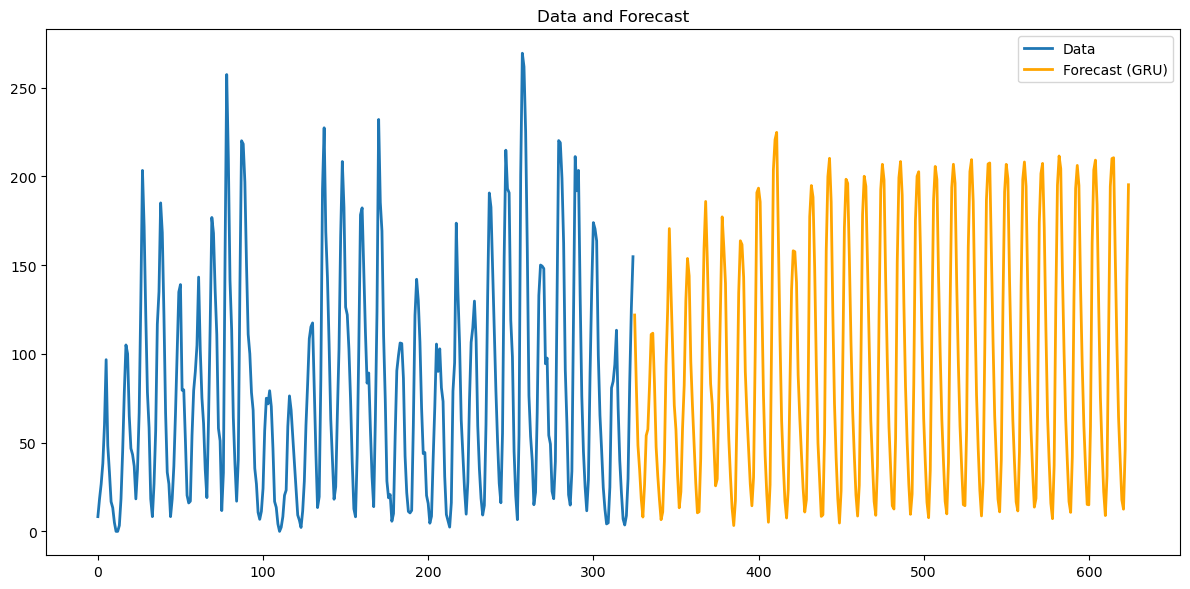

In [74]:
model.eval()
with torch.no_grad():
    _,h = model(X)
    preds = np.zeros(n_future,np.float32)
    last  = torch.tensor([[y_std[-1]]], dtype=torch.float32)
    for t in range(n_future):
        out,h = model(last.view(1,1,1),h)
        preds[t]=out.item()
        last = torch.tensor([[preds[t]]], dtype=torch.float32)

gru_preds_orig = preds*sig+mu
plt.figure(figsize=(12,6))
plt.plot(np.arange(len(y)),y,lw=2,label="Data")
plt.plot(np.arange(len(y),len(y)+n_future),gru_preds_orig, lw=2,label="Forecast (GRU)",color="orange")
plt.legend()
plt.title("Data and Forecast"); plt.legend(); plt.tight_layout(); plt.show()

Again the predictions do not look as realistic as those produced by the LSTM. 